### 0. Importing Necessary Libraries & Dependencies 

In [3]:
##-- Import libraries --##
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms
from helper_modules import data_setup, engine, utils
from tqdm.auto import tqdm

##-- Setup device agnostic code --##
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {device}")

##-- Setting up hyperparamters
BATCH_SIZE = 64
RANDOM_STATE = 42

ModuleNotFoundError: No module named 'utils'

### 1. Get Data

In [63]:
##-- Setup directory paths --##
from pathlib import Path
image_data_path = Path(r"C:\Users\nextt\Desktop\Hawking\eyeDx-research\aug_train_val")
train_dir = image_data_path / "train"
val_dir = image_data_path / "val"

train_dir, val_dir

(WindowsPath('C:/Users/nextt/Desktop/Hawking/eyeDx-research/aug_train_val/train'),
 WindowsPath('C:/Users/nextt/Desktop/Hawking/eyeDx-research/aug_train_val/val'))

### 2. Create Datasets & DataLoaders

#### 2.1 Creating a transforms for `torchvision.models` (manual creation)

In [64]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.465, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_tranforms = transforms.Compose([transforms.Resize((480, 480)),
                                       transforms.ToTensor(),
                                       normalize])

#### 2.2 Creating a transforms for `torchvision.models` (auto creation)

- As of `torchvision` v0.13_ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [65]:
##-- Get a set of pretrained model weights --##
weights_v2_m =torchvision.models.EfficientNet_V2_M_Weights.DEFAULT # 'DEFAULT' = best availabel weight
weights_v2_m

EfficientNet_V2_M_Weights.IMAGENET1K_V1

In [66]:
##-- Get the transforms used to create the pretrained weights
auto_transforms = weights_v2_m.transforms()
auto_transforms

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [67]:
##-- Create DataLoaders using auto_transforms --##
train_dataloader, val_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              val_dir=val_dir,
                                                                              transform=auto_transforms,
                                                                              batch_size=BATCH_SIZE)
train_dataloader, val_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x2de9e630410>,
 ['Central Serous Chorioretinopathy [Color Fundus]',
  'Diabetic Retinopathy',
  'Disc Edema',
  'Glaucoma',
  'Healthy',
  'Macular Scar',
  'Myopia',
  'Pterygium',
  'Retinal Detachment',
  'Retinitis Pigmentosa'])

### 3. Getting Pretrained Models

#### 3.1 Setting Up Pretrained Model

In [68]:
import torchvision
weights_v2_m = torchvision.models.EfficientNet_V2_M_Weights.DEFAULT # "DEFAULT" = get the best available weights
model_v2_m = torchvision.models.efficientnet_v2_m(weights=weights_v2_m).to(device)

In [69]:
print(f"{model_v2_m.avgpool}\n")
print(f"{model_v2_m.classifier}")

AdaptiveAvgPool2d(output_size=1)

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


#### 3.4 Getting Model Summary Using `torchinfo`

In [70]:
from torchinfo import summary

summary(model=model_v2_m,
        input_size=(1, 3, 480, 480), # [batch_size, color_channels, height, width],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 480, 480]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 480, 480]     [1, 1280, 15, 15]    --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 480, 480]     [1, 24, 240, 240]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 480, 480]     [1, 24, 240, 240]    648                  True
│    │    └─BatchNorm2d (1)                                  [1, 24, 240, 240]    [1, 24, 240, 240]    48                   True
│    │    └─SiLU (2)                                         [1, 24, 240, 240]    [1, 24, 240, 240]    --                   --
│    └─Sequential (1)                                        [1, 24, 240, 240]    [1, 24, 240,

#### 3.5 Freezing Base Model & Changing Output Layer Based On Our Needs

In [71]:
##-- Freeze all the base layers in EffNetB7 --##
for params in model_v2_m.features.parameters():
    params.requires_grad = False # won't updated the weights

In [72]:
##-- Update the classifier head of our model to suite our problem --##
from torch import nn

torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

model_v2_m.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # features vector coming in from the forzen layers
              out_features=len(class_names)).to(device))

In [73]:
summary(model=model_v2_m,
        input_size=(1, 3, 480, 480), # [batch_size, color_channels, height, width],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 480, 480]     [1, 10]              --                   Partial
├─Sequential (features)                                      [1, 3, 480, 480]     [1, 1280, 15, 15]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 480, 480]     [1, 24, 240, 240]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 480, 480]     [1, 24, 240, 240]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 240, 240]    [1, 24, 240, 240]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 240, 240]    [1, 24, 240, 240]    --                   --
│    └─Sequential (1)                                        [1, 24, 240, 240]    [1, 2

### 4. Train Model

In [74]:
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

##-- Define hyperparamters --##
EPOCHS = 30
LEARNING_RATE = 0.0001


##-- Define Loss & Optimizer --##
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v2_m.parameters(), lr=LEARNING_RATE)

##-- Start timer --##
from timeit import default_timer as timer
start_time = timer()

##-- Setup training and save the results --##
model_v2_m_results = engine.train(model=model_v2_m,
                               train_dataloader=train_dataloader,
                               val_dataloader=val_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=EPOCHS,
                               device=device)

##-- End timer --##
end_time = timer()

  3%|▎         | 1/30 [04:03<1:57:45, 243.65s/it]

Epoch: 1 | train_loss: 1.9442 | train_acc: 0.3366 | val_loss: 1.7317 | val_acc: 0.4370


  7%|▋         | 2/30 [07:27<1:42:42, 220.09s/it]

Epoch: 2 | train_loss: 1.6536 | train_acc: 0.4573 | val_loss: 1.5196 | val_acc: 0.4872


 10%|█         | 3/30 [11:33<1:44:20, 231.89s/it]

Epoch: 3 | train_loss: 1.4964 | train_acc: 0.5033 | val_loss: 1.3823 | val_acc: 0.5357


 13%|█▎        | 4/30 [15:38<1:42:42, 237.01s/it]

Epoch: 4 | train_loss: 1.3916 | train_acc: 0.5424 | val_loss: 1.2925 | val_acc: 0.5678


 17%|█▋        | 5/30 [19:42<1:39:49, 239.60s/it]

Epoch: 5 | train_loss: 1.3132 | train_acc: 0.5604 | val_loss: 1.2227 | val_acc: 0.5865


 20%|██        | 6/30 [23:47<1:36:35, 241.46s/it]

Epoch: 6 | train_loss: 1.2604 | train_acc: 0.5804 | val_loss: 1.1784 | val_acc: 0.6001


 23%|██▎       | 7/30 [27:52<1:32:59, 242.61s/it]

Epoch: 7 | train_loss: 1.2055 | train_acc: 0.5984 | val_loss: 1.1218 | val_acc: 0.6267


 27%|██▋       | 8/30 [31:56<1:29:08, 243.10s/it]

Epoch: 8 | train_loss: 1.1655 | train_acc: 0.6113 | val_loss: 1.0920 | val_acc: 0.6281


 30%|███       | 9/30 [35:58<1:24:59, 242.85s/it]

Epoch: 9 | train_loss: 1.1328 | train_acc: 0.6197 | val_loss: 1.0597 | val_acc: 0.6293


 33%|███▎      | 10/30 [40:00<1:20:52, 242.64s/it]

Epoch: 10 | train_loss: 1.1055 | train_acc: 0.6279 | val_loss: 1.0404 | val_acc: 0.6348


 37%|███▋      | 11/30 [44:01<1:16:39, 242.10s/it]

Epoch: 11 | train_loss: 1.0842 | train_acc: 0.6298 | val_loss: 1.0347 | val_acc: 0.6407


 40%|████      | 12/30 [47:42<1:10:41, 235.67s/it]

Epoch: 12 | train_loss: 1.0592 | train_acc: 0.6418 | val_loss: 1.0078 | val_acc: 0.6448


 43%|████▎     | 13/30 [51:44<1:07:17, 237.49s/it]

Epoch: 13 | train_loss: 1.0479 | train_acc: 0.6438 | val_loss: 0.9810 | val_acc: 0.6538


 47%|████▋     | 14/30 [55:48<1:03:52, 239.56s/it]

Epoch: 14 | train_loss: 1.0296 | train_acc: 0.6502 | val_loss: 0.9732 | val_acc: 0.6573


 50%|█████     | 15/30 [59:46<59:46, 239.09s/it]  

Epoch: 15 | train_loss: 1.0210 | train_acc: 0.6492 | val_loss: 0.9444 | val_acc: 0.6666


 53%|█████▎    | 16/30 [1:03:42<55:34, 238.19s/it]

Epoch: 16 | train_loss: 1.0032 | train_acc: 0.6592 | val_loss: 0.9477 | val_acc: 0.6649


 57%|█████▋    | 17/30 [1:07:41<51:36, 238.21s/it]

Epoch: 17 | train_loss: 0.9904 | train_acc: 0.6603 | val_loss: 0.9284 | val_acc: 0.6717


 60%|██████    | 18/30 [1:11:39<47:40, 238.38s/it]

Epoch: 18 | train_loss: 0.9818 | train_acc: 0.6587 | val_loss: 0.9181 | val_acc: 0.6735


 63%|██████▎   | 19/30 [1:15:38<43:44, 238.57s/it]

Epoch: 19 | train_loss: 0.9718 | train_acc: 0.6628 | val_loss: 0.9163 | val_acc: 0.6776


 67%|██████▋   | 20/30 [1:19:37<39:44, 238.44s/it]

Epoch: 20 | train_loss: 0.9631 | train_acc: 0.6640 | val_loss: 0.9036 | val_acc: 0.6789


 70%|███████   | 21/30 [1:23:36<35:49, 238.80s/it]

Epoch: 21 | train_loss: 0.9539 | train_acc: 0.6652 | val_loss: 0.9041 | val_acc: 0.6785


 73%|███████▎  | 22/30 [1:27:35<31:51, 238.96s/it]

Epoch: 22 | train_loss: 0.9459 | train_acc: 0.6682 | val_loss: 0.8890 | val_acc: 0.6770


 77%|███████▋  | 23/30 [1:31:35<27:53, 239.07s/it]

Epoch: 23 | train_loss: 0.9406 | train_acc: 0.6694 | val_loss: 0.8873 | val_acc: 0.6793


 80%|████████  | 24/30 [1:35:34<23:53, 238.99s/it]

Epoch: 24 | train_loss: 0.9342 | train_acc: 0.6700 | val_loss: 0.8776 | val_acc: 0.6816


 83%|████████▎ | 25/30 [1:39:32<19:53, 238.71s/it]

Epoch: 25 | train_loss: 0.9317 | train_acc: 0.6754 | val_loss: 0.8816 | val_acc: 0.6815


 87%|████████▋ | 26/30 [1:43:32<15:56, 239.08s/it]

Epoch: 26 | train_loss: 0.9186 | train_acc: 0.6812 | val_loss: 0.8691 | val_acc: 0.6835


 90%|█████████ | 27/30 [1:47:29<11:55, 238.45s/it]

Epoch: 27 | train_loss: 0.9125 | train_acc: 0.6777 | val_loss: 0.8629 | val_acc: 0.6853


 93%|█████████▎| 28/30 [1:51:25<07:55, 237.93s/it]

Epoch: 28 | train_loss: 0.9135 | train_acc: 0.6783 | val_loss: 0.8597 | val_acc: 0.6856


 97%|█████████▋| 29/30 [1:55:24<03:58, 238.12s/it]

Epoch: 29 | train_loss: 0.9091 | train_acc: 0.6787 | val_loss: 0.8597 | val_acc: 0.6841


100%|██████████| 30/30 [1:59:19<00:00, 238.66s/it]

Epoch: 30 | train_loss: 0.9023 | train_acc: 0.6810 | val_loss: 0.8430 | val_acc: 0.6959


TypeError: save_model() got an unexpected keyword argument 'current_epoch'

In [4]:
##- Save the model --##
from helper_modules import utils
utils.save_model(model=model_v2_m,
                 target_dir="./saved_models",
                 model_name=f"efficientnet_v2_m_{EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.pth",
                 optimizer=optimizer,
                 epoch=EPOCHS)

print(f"[INFO]: Total training time: {(end_time-start_time)/60:.2f} minutes.")

NameError: name 'model_v2_m' is not defined

### 5. Evaluate Model

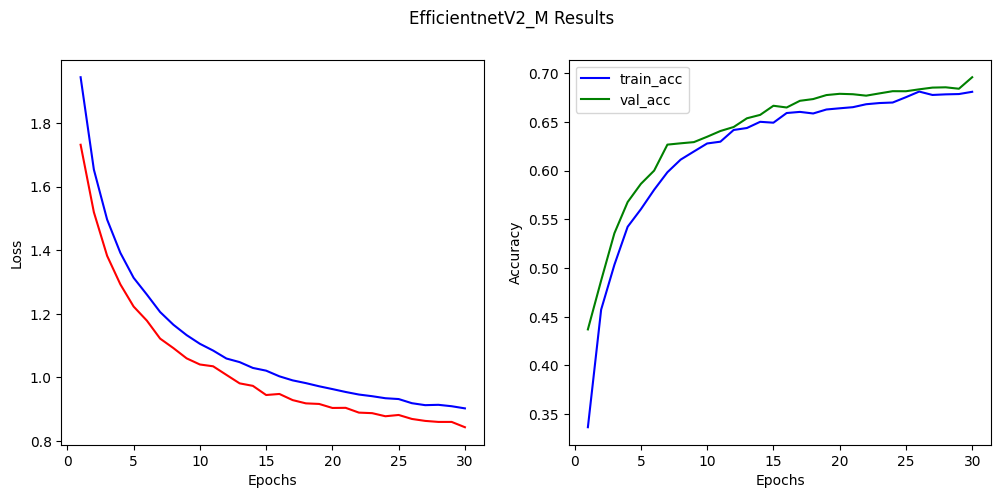

In [79]:
##-- Plot loss curves --##
epochs = [i for i in range(1, EPOCHS+1)]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, model_v2_m_results["train_loss"], color="blue", label="train_loss")
plt.plot(epochs, model_v2_m_results["val_loss"], color="red", label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, model_v2_m_results["train_acc"], color="blue", label="train_acc")
plt.plot(epochs, model_v2_m_results["val_acc"], color="green", label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.suptitle("EfficientnetV2_M Results")
plt.savefig(f"plot_v2_m_{EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.png")
plt.legend()
plt.show()